In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Search is started.
0- time: 0.02, count_rollouts: 1, reward: -0.896546208687637, node: PEPTIDE1{G.G.S.R.R.S.R.W.W}$$$$
1- time: 0.18, count_rollouts: 2, reward: -0.9476076885652479, node: PEPTIDE1{[ac].Y.T.S.L.I.E.E.L.I.K.K.S.E.E.Q.Q.K.K.N.E.E.E.L.K.K.L.E.E.W.A.K.K.W.N.W.F.[am]}$$$$
2- time: 0.26, count_rollouts: 3, reward: -0.6531287992917922, node: PEPTIDE1{[ac].[Nle].F.R.W.[am]}$$$$
3- time: 0.27, count_rollouts: 4, reward: -0.8840130335515616, node: PEPTIDE1{R.P.[dK].[dP].[dQ].[dQ].[dF].F.G.[dL].M.[am]}$$$$
4- time: 0.30, count_rollouts: 5, reward: -0.6416868213790997, node: PEPTIDE1{Y.A.A}$$$$
5- time: 0.31, count_rollouts: 6, reward: -0.7948221105677934, node: PEPTIDE1{G.R.V.F.I.I.K.I.W}$$$$
6- time: 0.33, count_rollouts: 7, reward: -0.9189230234074356, node: PEPTIDE1{F.G.G.F.T.G.A.R.K.S.A.R.K.[am]}$$$$
7- time: 0.36, count_rollouts: 8, reward: 0.944805747347579, node: PEPTIDE1{A.S.A.[Nle].[am]}$$$$
8- time: 0.37, count_rollouts: 9, reward: -0.9057956351845688, node: PEPTIDE1{A.A

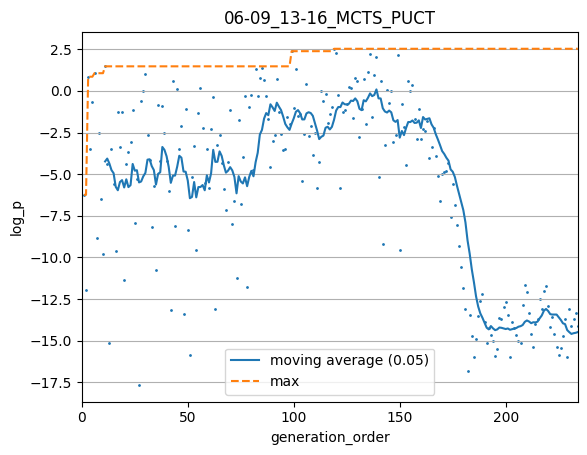

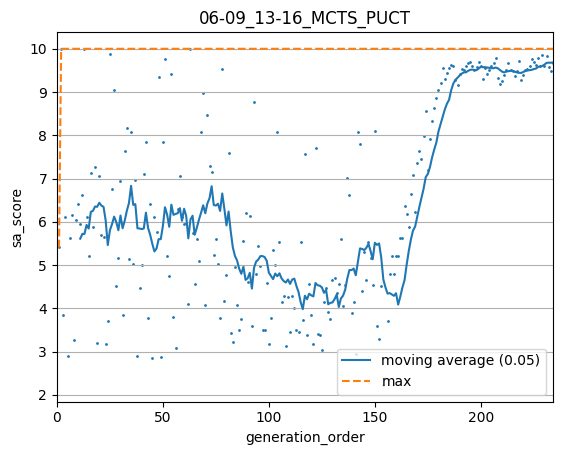

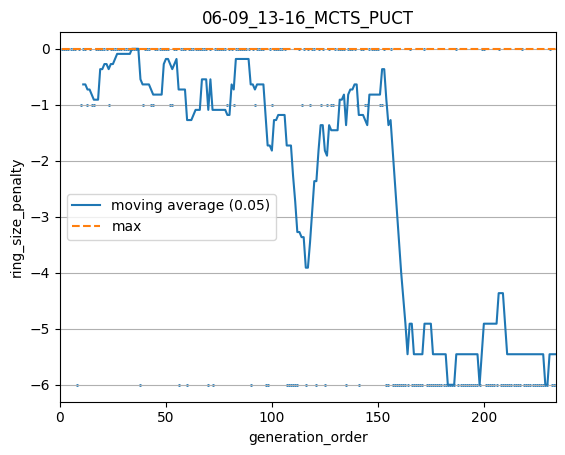

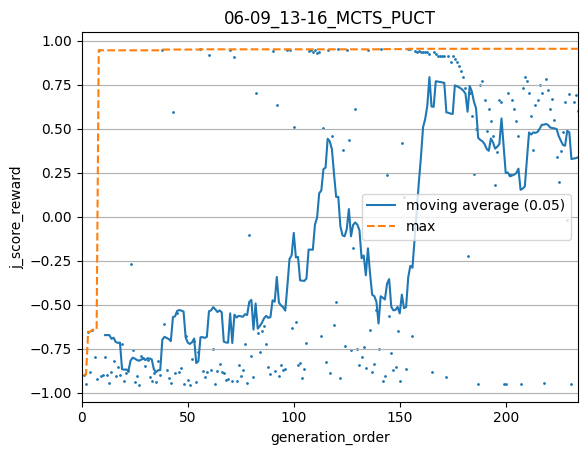

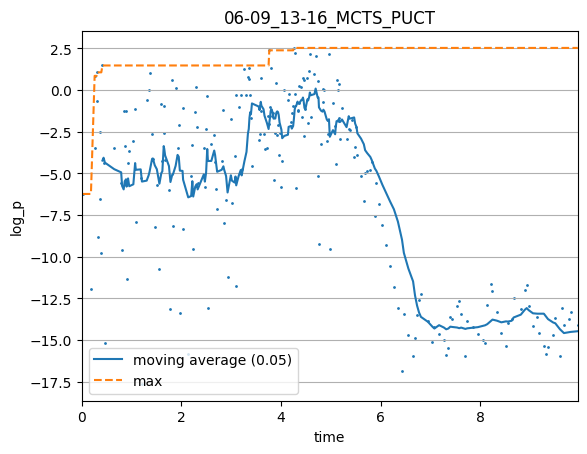

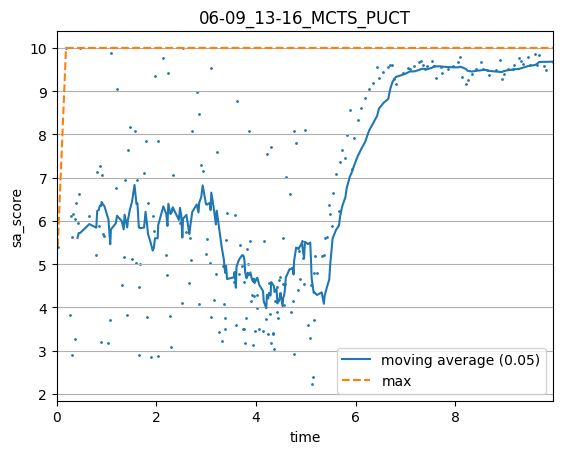

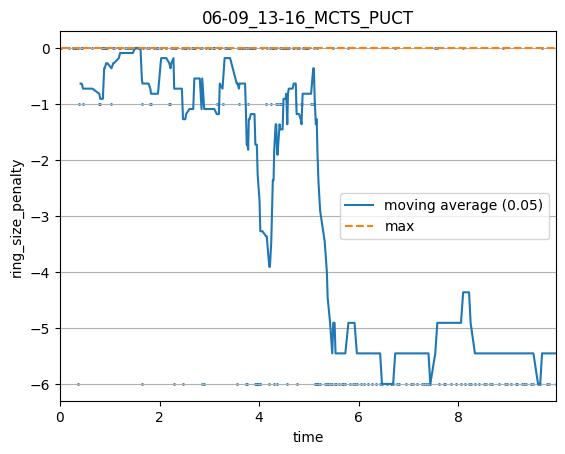

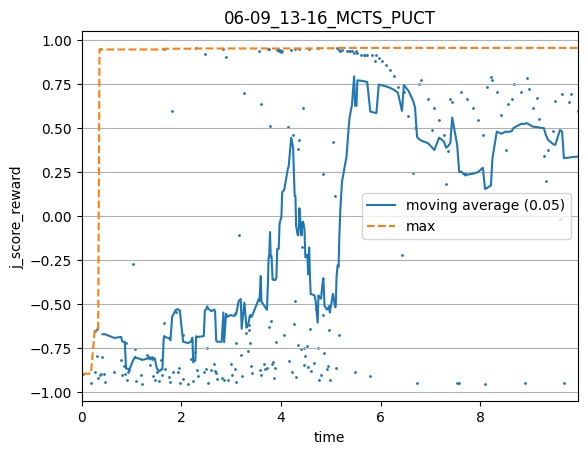

In [3]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)